## Compras realizadas por los municipios de la Región de Los Lagos entre los años 2022 y 2023

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import random
import unidecode
def remove_accents(a):
    return unidecode.unidecode(a)
import glob
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community import asyn_lpa_communities
from networkx.algorithms.community import greedy_modularity_communities

Este análisis se centra en las compras realizadas mediante licitación pública por las municipalidades de la región de Los Lagos entre los años 2022 y 2023. La elección de esta región responde al interés de diversificar el enfoque y aportar información de otras zonas del país, evitando la concentración en la región Metropolitana en desmedro de otras regiones.

En el análisis de proveedores, no existe una relación uniforme entre ellos, ya que las licitaciones abarcan distintos tipos de productos y servicios, con proveedores específicos para cada área. En este contexto, se seleccionó el rubro de servicios de construcción. Esta elección se basa en la relevancia de la construcción en la práctica laboral de la región, caracterizada por un alto número de trabajadores formales e informales dedicados a la carpintería y la albañilería. Además, los negocios de productos de construcción se destacan en las ciudades de la zona.
El objetivo del análisis es observar la frecuencia y el comportamiento de las licitaciones en el sector de construcción y explorar cómo interactúan los proveedores en este contexto, con especial interés en identificar patrones y comportamientos de competencia o colaboración dentro de la comunidad de proveedores en esta área.


Los datos analizados provienen de múltiples archivos CSV, los cuales se unificaron en un solo DataFrame inicial para facilitar la revisión, limpieza y filtrado de las variables necesarias para el análisis. Durante este proceso, se comprobó que los datos no requerían máyor limpieza o transformación, excepto la variable ‘MontoTotalOferta’ que del tipo stringe pasó a float, en el caso de usarse y no se quiere generar error se cambía la tipología. stringe generaría error. 

El análisis se centra en la selección de variables y categorías claves para construir el grafo o los grafos necesarios. Para ello, se utilizó el análisis de frecuencias, que orientó la selección de datos relevantes. A continuación, se detallan los DataFrames generados y su propósito:

1. **Concatenado**: Contiene 13 variables seleccionadas de los archivos originales, enfocándose en aquellas más relevantes para el análisis.

   - **NroLicitacion**: Identificación única de cada licitación generada por el municipio.
   - **TipoLicitacion**: Clasificación de la licitación según su valor, expresado en UTM (Unidad Tributaria Mensual).
   - **MonedaLicitacion**: Tipo de moneda de los montos asignados; UTM es la más común, pero pueden existir otras.
   - **MontoEstimadoLicitacion**: Dinero asignado para la adquisición del servicio o producto.
   - **EstadoLicitacion**: Variable que indica  si la licitación fue adjudicada, desierta, cerrada, etc.
   - **Institucion**: Nombre del municipio que organiza la licitación.
   - **RubroN1**: Área económica a la que pertenece el producto o servicio requerido por el municipio.
   - **Proveedor**: Nombre del proveedor que participa en la licitación.
   - **ActividadProveedor**: Rubro económico de la empresa proveedora.
   - **TamanoProveedor**: Tamaño del proveedor.
   - **EstadoOferta**: Indica si pasó la primera etapa.
   - **MontoTotalOferta**: Valor ofertado por el proveedor.
   - **ResultadoOferta**: Base que contiene solo a los ganadores de las licitaciones. 
   -
     

2. **Municipios**: Contiene información solo de los municipios de la región de Los Lagos.

3. **licitaciones**: Registra a los proveedores que participan en cada licitación y elimina valores duplicados.
   
4. **Participación**: Corresponde a los proveedores que participaron en las licitaciones del área de Servicios de construcción. 

5. **Resultado**: Contiene a los proveedores que ganaron en las licitaciones realizadas.  

### Pregunta de investigación

**¿Qué proveedores tienden a competir en las licitaciones organizadas por los mismos municipios, y cuáles de estos proveedores tienen una influencia central o forman grupos dentro de las comunidades de competencia?**

#### Carga de datos

In [8]:
# Listar los archivos a revisión y concatenación

# Ruta de los archivos CSV
ruta_archivos = 'C:/Users/Paula/Documents/Diplomado UDD/3° Trimestre/Ciencia de Redes/Tarea Final/Licitaciones/*.csv'

# Usamos glob para listar todos los archivos encontrados
lista_archivos = glob.glob(ruta_archivos)
lista_archivos

['C:/Users/Paula/Documents/Diplomado UDD/3° Trimestre/Ciencia de Redes/Tarea Final/Licitaciones\\04LicitacionesAbr2022_1sem.csv',
 'C:/Users/Paula/Documents/Diplomado UDD/3° Trimestre/Ciencia de Redes/Tarea Final/Licitaciones\\04LicitacionesAbr2023_1sem.csv',
 'C:/Users/Paula/Documents/Diplomado UDD/3° Trimestre/Ciencia de Redes/Tarea Final/Licitaciones\\04LicitacionesAgo2022_2sem.csv',
 'C:/Users/Paula/Documents/Diplomado UDD/3° Trimestre/Ciencia de Redes/Tarea Final/Licitaciones\\04LicitacionesAgo2023_2sem.csv',
 'C:/Users/Paula/Documents/Diplomado UDD/3° Trimestre/Ciencia de Redes/Tarea Final/Licitaciones\\04LicitacionesDic2022_2sem.csv',
 'C:/Users/Paula/Documents/Diplomado UDD/3° Trimestre/Ciencia de Redes/Tarea Final/Licitaciones\\04LicitacionesDic2023_2sem.csv',
 'C:/Users/Paula/Documents/Diplomado UDD/3° Trimestre/Ciencia de Redes/Tarea Final/Licitaciones\\04LicitacionesEne2022_1sem.csv',
 'C:/Users/Paula/Documents/Diplomado UDD/3° Trimestre/Ciencia de Redes/Tarea Final/Licitac

#### Procesamiento de datos

In [10]:
# Data frame total de los datos de las licitaciones

# Lista de columnas que queremos leer
columnas_deseadas = [
    'NroLicitacion', 'TipoLicitacion', 'MonedaLicitacion', 'MontoEstimadoLicitacion', 
    'EstadoLicitacion', 'Institucion', 'RubroN1', 'Proveedor',  'ActividadProveedor',
    'TamanoProveedor', 'EstadoOferta', 'MontoTotalOferta', 'ResultadoOferta'
    
]

# Leemos y concatenamos los archivos en un solo DataFrame, ignorando filas con errores
concatenado = pd.concat([pd.read_csv(archivo, sep=';', encoding='ISO-8859-1', usecols=columnas_deseadas, on_bad_lines='skip') 
                            for archivo in lista_archivos], ignore_index=True)

# Mostrar las primeras filas del DataFrame concatenado
concatenado.head(1)

C:\Users\Paula\AppData\Local\Temp\ipykernel_16248\2915688832.py:12: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  concatenado = pd.concat([pd.read_csv(archivo, sep=';', encoding='ISO-8859-1', usecols=columnas_deseadas, on_bad_lines='skip')


,NroLicitacion,TipoLicitacion,MonedaLicitacion,MontoEstimadoLicitacion,EstadoLicitacion,Institucion,RubroN1,Proveedor,ActividadProveedor,TamanoProveedor,EstadoOferta,MontoTotalOferta,ResultadoOferta
0,2585-122-LE21,Licitación Pública Entre 100 y 1000 UTM (LE),CLP,5184000,Adjudicada,I MUNICIPALIDAD DE ARICA,"Tecnologías de la información, telecomunicacio...",MOYA CONTRERAS ANGEL GABRIEL Y OTRO,VENTA AL POR MAYOR DE OTROS PRODUCTOS N.C.P.| ...,Pequeña,Aceptada,1,Ganadora


In [11]:
concatenado.shape

(5381646, 13)

In [12]:
print(concatenado.dtypes)

NroLicitacion              object
TipoLicitacion             object
MonedaLicitacion           object
MontoEstimadoLicitacion     int64
EstadoLicitacion           object
Institucion                object
RubroN1                    object
Proveedor                  object
ActividadProveedor         object
TamanoProveedor            object
EstadoOferta               object
MontoTotalOferta           object
ResultadoOferta            object
dtype: object


In [13]:
concatenado['MontoTotalOferta'] = concatenado['MontoTotalOferta'].str.replace(',', '.').astype(float)

In [14]:
print(concatenado.dtypes)

NroLicitacion               object
TipoLicitacion              object
MonedaLicitacion            object
MontoEstimadoLicitacion      int64
EstadoLicitacion            object
Institucion                 object
RubroN1                     object
Proveedor                   object
ActividadProveedor          object
TamanoProveedor             object
EstadoOferta                object
MontoTotalOferta           float64
ResultadoOferta             object
dtype: object


In [15]:
# Dataframe con solo los municipios de la Región de Los Lagos

# Lista de instituciones que quieres filtrar
instituciones = [
    'CORP MUNICIPAL DE CASTRO PARA LA EDUCACION SALUD Y ATENCION AL MENOR',
    'I MUNICIPALIDAD DE ANCUD',
    'I MUNICIPALIDAD DE CALBUCO',
    'I MUNICIPALIDAD DE CASTRO',
    'I MUNICIPALIDAD DE CHAITEN',
    'I MUNICIPALIDAD DE CHONCHI',
    'I MUNICIPALIDAD DE CURACO DE VELEZ',
    'I MUNICIPALIDAD DE DALCAHUE',
    'I MUNICIPALIDAD DE FRESIA',
    'I MUNICIPALIDAD DE FRUTILLAR',
    'I MUNICIPALIDAD DE FUTALEUFU',
    'I MUNICIPALIDAD DE HUALAIHUE',
    'I MUNICIPALIDAD DE LLANQUIHUE',
    'I MUNICIPALIDAD DE LOS LAGOS',
    'I MUNICIPALIDAD DE LOS MUERMOS',
    'I MUNICIPALIDAD DE MAULLIN',
    'I MUNICIPALIDAD DE OSORNO',
    'I MUNICIPALIDAD DE PALENA',
    'I MUNICIPALIDAD DE PUERTO MONTT',
    'I MUNICIPALIDAD DE PUERTO VARAS',
    'I MUNICIPALIDAD DE PUQUELDON',
    'I MUNICIPALIDAD DE PURRANQUE',
    'I MUNICIPALIDAD DE QUEILEN',
    'I MUNICIPALIDAD DE QUEMCHI',
    'I MUNICIPALIDAD DE QUINCHAO',
    'I MUNICIPALIDAD DE RIO NEGRO',
    'I MUNICIPALIDAD DE SAN PABLO',
    'I MUNICIPALIDAD PUERTO OCTAY',
    'Ilustre Municipalidad De Quellón',
    'Ilustre Municipalidad de San Juan de la Costa'
]

# Filtrar el DataFrame con las instituciones mencionadas
municipios = concatenado[concatenado['Institucion'].isin(instituciones)]

municipios.head(1)

,NroLicitacion,TipoLicitacion,MonedaLicitacion,MontoEstimadoLicitacion,EstadoLicitacion,Institucion,RubroN1,Proveedor,ActividadProveedor,TamanoProveedor,EstadoOferta,MontoTotalOferta,ResultadoOferta
304,2289-13-LE22,Licitación Pública Entre 100 y 1000 UTM (LE),CLP,7563025,Adjudicada,I MUNICIPALIDAD DE FRUTILLAR,"Servicios de transporte, almacenaje y correo",SOCIEDAD INGENIERÍA OTTO WERKE LIMITADA,mantenimiento y reparación de vehículos,Micro,Aceptada,12818308.0,Perdedora


In [16]:
municipios.shape

(421980, 13)

In [17]:
# Data frame que limpia la columna de Nrolicitaciones. Evita repeticiones del tipo proveedor en la misma licitacion. 

licitaciones = municipios.drop_duplicates(subset=['NroLicitacion', 'Institucion', 'Proveedor'])

licitaciones.head(1)

,NroLicitacion,TipoLicitacion,MonedaLicitacion,MontoEstimadoLicitacion,EstadoLicitacion,Institucion,RubroN1,Proveedor,ActividadProveedor,TamanoProveedor,EstadoOferta,MontoTotalOferta,ResultadoOferta
304,2289-13-LE22,Licitación Pública Entre 100 y 1000 UTM (LE),CLP,7563025,Adjudicada,I MUNICIPALIDAD DE FRUTILLAR,"Servicios de transporte, almacenaje y correo",SOCIEDAD INGENIERÍA OTTO WERKE LIMITADA,mantenimiento y reparación de vehículos,Micro,Aceptada,12818308.0,Perdedora


In [18]:
licitaciones.shape

(36967, 13)

In [151]:
# Frecuencia de la cantidad de PROVEEDORES agrupados segun la actividades económica en la que participan. 

# Agrupar por 'RubroN1' y 'Proveedor', luego contar la cantidad de proveedores por cada área
proveedores_por_area = licitaciones.groupby('RubroN1')['Proveedor'].nunique()

# Ordenar el resultado para ver qué áreas tienen más proveedores participantes
proveedores_por_area_sorted = proveedores_por_area.sort_values(ascending=False)

# Guardar el resultado en un archivo 
#proveedores_por_area_sorted.to_excel('proveedores_por_area.xlsx', index=True)

# Mostrar el resultado
proveedores_por_area_sorted.head(10)

RubroN1
Servicios profesionales, administrativos y consultorías de gestión empresarial    1011
Servicios de construcción y mantenimiento                                          879
Equipamiento y suministros médicos                                                 687
Artículos para estructuras, obras y construcciones                                 611
Tecnologías de la información, telecomunicaciones y radiodifusión                  499
Servicios de transporte, almacenaje y correo                                       463
Artículos eléctricos y de iluminación                                              347
Artículos de fabricación y producción                                              334
Ropa, maletas y productos de aseo personal                                         323
Equipos, accesorios y suministros de oficina                                       322
Name: Proveedor, dtype: int64

In [153]:
# Frecuencia de las LICITACIONES agrupadas segun la actividades económica en la que participan. 

# Agrupar por 'RubroN1' y 'N°Licitacion', luego contar la cantidad de licitaciones por cada área

licitaciones_por_area = licitaciones.groupby('RubroN1')['NroLicitacion'].nunique()

# Ordenar el resultado para ver qué áreas tienen más proveedores participantes
licitaciones_por_area_sorted = licitaciones_por_area.sort_values(ascending=False)

# Guardar el resultado en un archivo
#licitaciones_por_area_sorted.to_excel('licitaciones_por_area.xlsx', index=True)

# Mostrar el resultado
licitaciones_por_area_sorted.head(10)

RubroN1
Servicios de construcción y mantenimiento                                         1080
Servicios profesionales, administrativos y consultorías de gestión empresarial     694
Equipamiento y suministros médicos                                                 623
Servicios de transporte, almacenaje y correo                                       590
Artículos para estructuras, obras y construcciones                                 532
Tecnologías de la información, telecomunicaciones y radiodifusión                  506
Equipos, accesorios y suministros de oficina                                       379
Artículos de fabricación y producción                                              344
Vehículos y equipamiento en general                                                343
Productos derivados de minerales, plantas y animales                               336
Name: NroLicitacion, dtype: int64

In [155]:
# Valor de las LICITACIONES segun la actividades económica en la que participan. 

# Dinero involucrado por cada área

dinero_por_area = licitaciones.groupby('RubroN1')['MontoTotalOferta'].sum()

# Ordenar el resultado para ver qué áreas tienen más proveedores participantes
dinero_por_area_sorted = dinero_por_area.sort_values(ascending=False)

# Guardar el resultado en un archivo
#licitaciones_por_area_sorted.to_excel('licitaciones_por_area.xlsx', index=True)

# Mostrar el resultado
dinero_por_area_sorted.head(10)

RubroN1
Servicios de construcción y mantenimiento                                         6.040312e+13
Servicios de limpieza industrial                                                  1.001663e+13
Equipos y suministros de defensa, orden público, protección y seguridad           9.346446e+10
Instrumentos musicales, juegos, juguetes, artesanías y materiales educativos      5.312936e+10
Equipamiento y suministros médicos                                                3.372198e+10
Servicios profesionales, administrativos y consultorías de gestión empresarial    2.727949e+10
Servicios de defensa nacional, orden público y seguridad                          2.577980e+10
Equipos, accesorios y suministros de oficina                                      1.983117e+10
Vehículos y equipamiento en general                                               1.867398e+10
Tecnologías de la información, telecomunicaciones y radiodifusión                 1.767049e+10
Name: MontoTotalOferta, dtype: float64

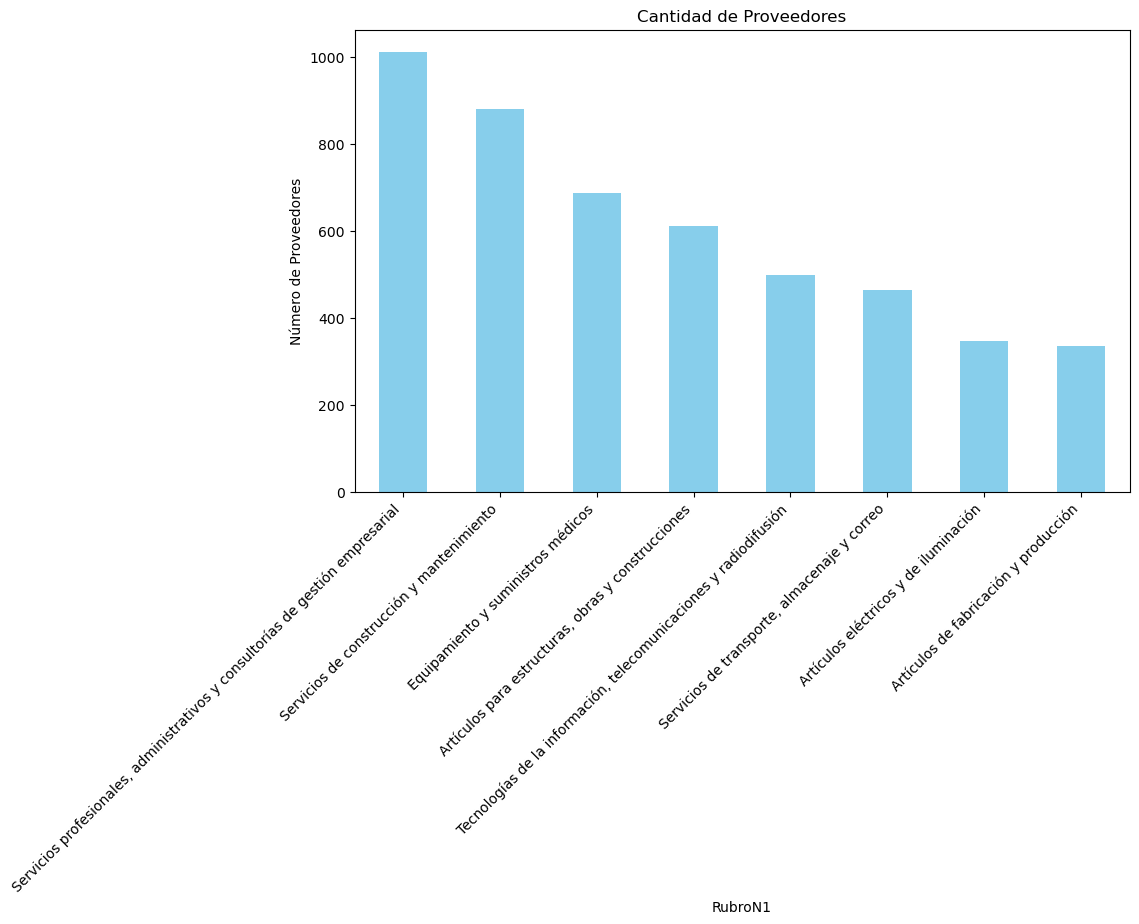

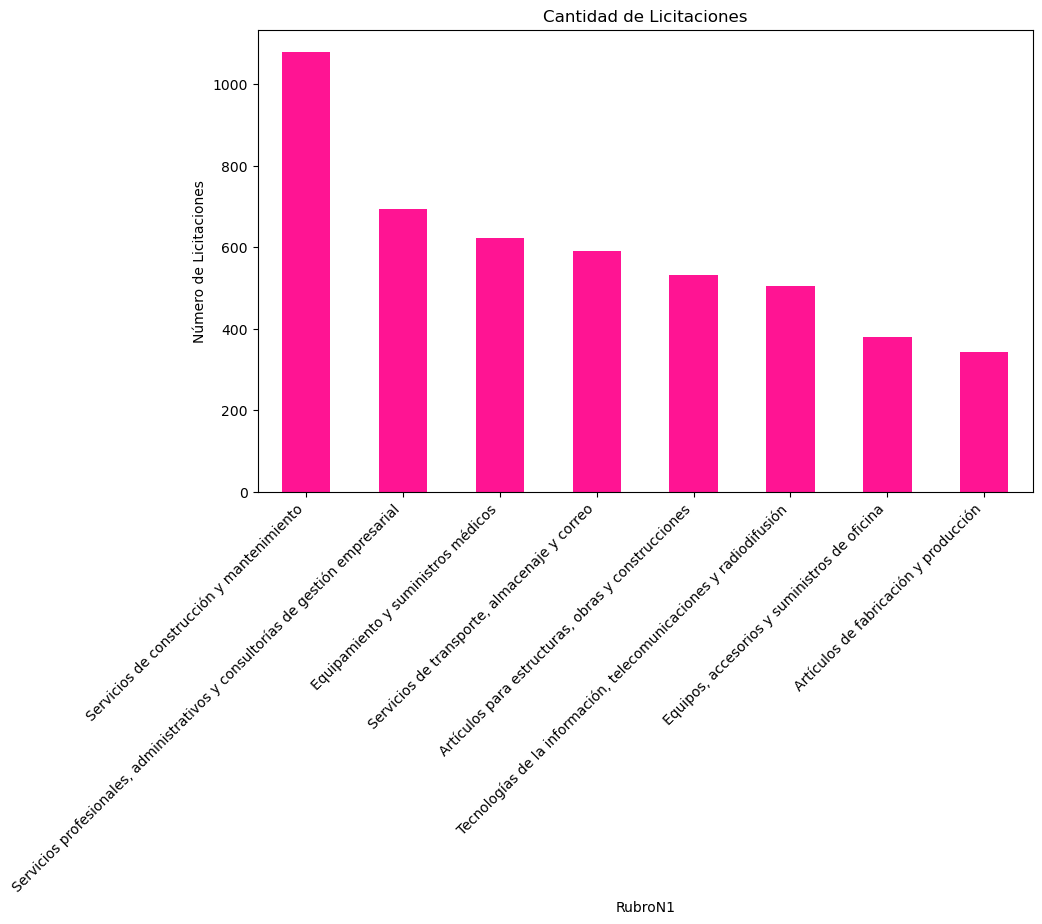

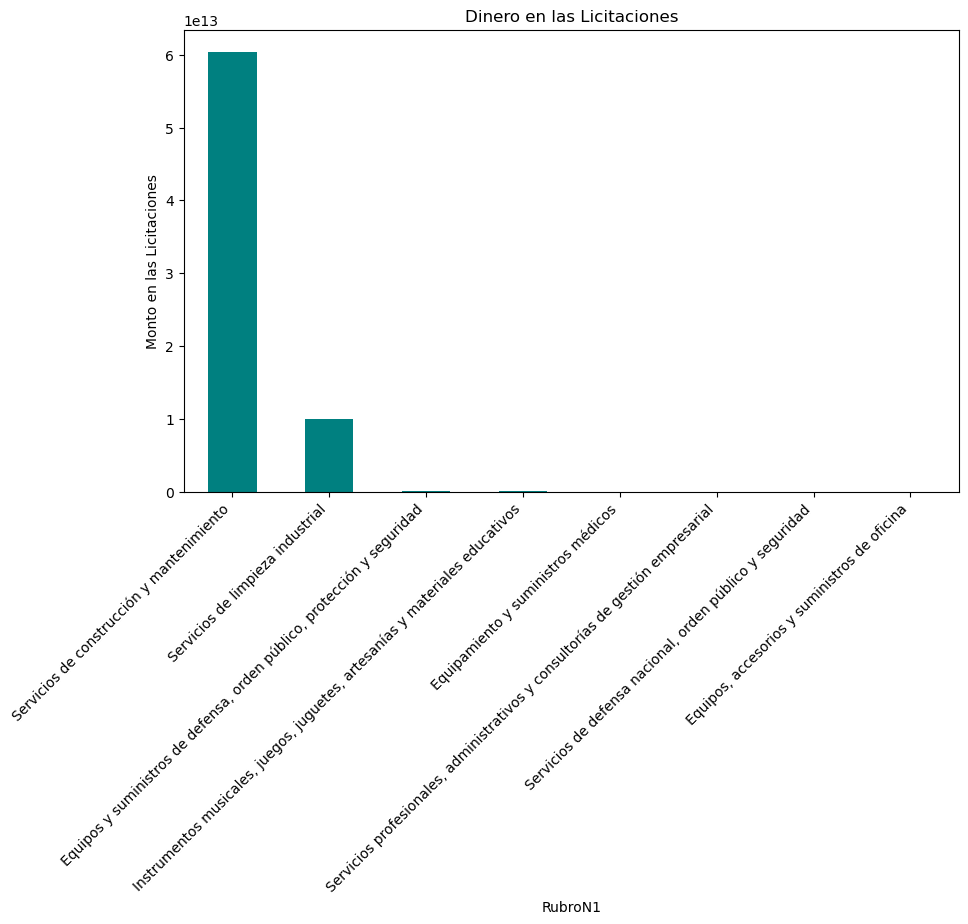

In [157]:
# Gráficos de frecuencias 

# Seleccionar los 8 primeros
top_p = proveedores_por_area_sorted.head(8)

# Generar el gráfico de barras
plt.figure(figsize=(10, 6))
top_p.plot(kind='bar', color="skyblue")
plt.title('Cantidad de Proveedores')
plt.ylabel('Número de Proveedores')
plt.xticks(rotation=45, ha='right')
plt.show()

# Seleccionar los 8 primeros
top_a = licitaciones_por_area_sorted.head(8)

# Generar el gráfico de barras
plt.figure(figsize=(10, 6))
top_a.plot(kind='bar', color="deeppink")
plt.title('Cantidad de Licitaciones')
plt.ylabel('Número de Licitaciones')
plt.xticks(rotation=45, ha='right')
plt.show()

# Seleccionar los 8 primeros
top_d = dinero_por_area_sorted.head(8)

# Generar el gráfico de barras
plt.figure(figsize=(10, 6))
top_d.plot(kind='bar', color="teal")
plt.title('Dinero en las Licitaciones')
plt.ylabel('Monto en las Licitaciones')
plt.xticks(rotation=45, ha='right')
plt.show()

In [22]:
# Dataframe con los municipios de la Región y que tiene 
# solo licitaciones del área Servicio de Construcción 

# Filtrar el DataFrame con el rubro mencionado
participacion = licitaciones[licitaciones['RubroN1'] == 'Servicios de construcción y mantenimiento']

participacion.head(1)

,NroLicitacion,TipoLicitacion,MonedaLicitacion,MontoEstimadoLicitacion,EstadoLicitacion,Institucion,RubroN1,Proveedor,ActividadProveedor,TamanoProveedor,EstadoOferta,MontoTotalOferta,ResultadoOferta
8744,966131-22-LP22,Licitación Pública Mayor 1000 UTM (LP),CLP,74757825,Adjudicada,I MUNICIPALIDAD DE CASTRO,Servicios de construcción y mantenimiento,SOCIEDAD INMOBILIARIA Y CONSTRUCCIONES ASGARD SPA,REPARACION DE MAQUINARIA AGROPECUARIA Y FORESTAL,Micro,Aceptada,74757825.0,Ganadora


In [23]:
# Generar un excel en relación al dataframe
try:
    participacion.to_excel('participacion_lic.xlsx', index=False)  # index=False para no incluir el índice del DataFrame en el archivo
    
    print("Archivo Excel creado con éxito.")
except Exception as e:
    print(f"Error al crear el archivo Excel: {e}")

Archivo Excel creado con éxito.


In [24]:
#Dataframe con los ganadores de cada licitacion

# Filtrar de la variable 'ResultadoOferta' el valor 'Ganadora'
resultado = participacion[participacion['ResultadoOferta'] == 'Ganadora']

# Mostrar las primeras filas del DataFrame filtrado
resultado.head(1)

,NroLicitacion,TipoLicitacion,MonedaLicitacion,MontoEstimadoLicitacion,EstadoLicitacion,Institucion,RubroN1,Proveedor,ActividadProveedor,TamanoProveedor,EstadoOferta,MontoTotalOferta,ResultadoOferta
8744,966131-22-LP22,Licitación Pública Mayor 1000 UTM (LP),CLP,74757825,Adjudicada,I MUNICIPALIDAD DE CASTRO,Servicios de construcción y mantenimiento,SOCIEDAD INMOBILIARIA Y CONSTRUCCIONES ASGARD SPA,REPARACION DE MAQUINARIA AGROPECUARIA Y FORESTAL,Micro,Aceptada,74757825.0,Ganadora


In [25]:
resultado.shape

(1060, 13)

In [26]:
# Generar un excel en relación al dataframe
try:
    resultado.to_excel('resultados_lic.xlsx', index=False)  # index=False para no incluir el índice del DataFrame en el archivo
    
    print("Archivo Excel creado con éxito.")
except Exception as e:
    print(f"Error al crear el archivo Excel: {e}")

Archivo Excel creado con éxito.


#### Análisis de redes

In [28]:
# Valores descriptivo de un grafo

def calculate_basic_measures(G):
    N = G.number_of_nodes()
    L = G.number_of_edges()
    degrees = [deg for node, deg in G.degree()]
    kmin = min(degrees)
    kmax = max(degrees)
    mean_degree = np.mean(degrees)
    print("**********************************")
    print(f"Número de nodos: {N}")
    print(f"Número de enlaces: {L}")
    print(f"Grado mínimo: {kmin}")
    print(f"Grado máximo: {kmax}")
    print(f"Grado promedio: {mean_degree}")
    print("**********************************")    

#### Construcción de la red

#### grafo participación: G_P 

La red se construye considerando a los proveedores como nodos ya que ellos son el principal foco de interés. Las aristas o conexiones entre los nodos representan los municipios que emitieron licitaciones, generando oportunidades de competencia entre proveedores al participar en licitaciones en un mismo municipio. Este enfoque facilita el análisis de patrones de concentración o competencia regional entre los proveedores.

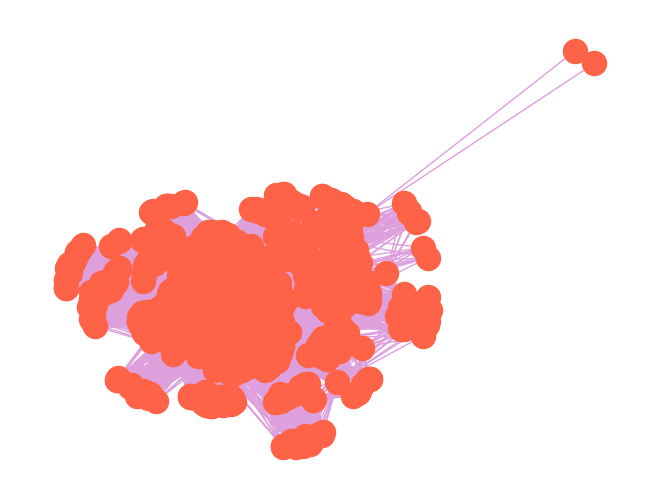

In [32]:
# Grafo bipartito entre municipios e instituciones

G_bipartito = nx.Graph()
for index, row in participacion.iterrows():
    G_bipartito.add_edge(row['Institucion'], row['Proveedor'])

# Proyectar el grafo bipartito sobre los proveedores
G_P = nx.bipartite.weighted_projected_graph(G_bipartito, participacion['Proveedor'].unique())

nx.draw(G_P, with_labels=False, node_color='tomato', edge_color='plum')

In [33]:
print("Número de nodos en G_bipartito:", G_bipartito.number_of_nodes())
print("Número de aristas en G_bipartito:", G_bipartito.number_of_edges())

print("Número de nodos en G_P:", G_P.number_of_nodes())
print("Número de aristas en G_P:", G_P.number_of_edges())


Número de nodos en G_bipartito: 909
Número de aristas en G_bipartito: 1407
Número de nodos en G_P: 879
Número de aristas en G_P: 55296


In [34]:
# Generar archivo excel del grafo 
# Crear una lista de aristas (conexiones) con sus pesos
edges = [(u, v, d['weight']) for u, v, d in G_P.edges(data=True)]

# Convertir a un DataFrame
df_edges = pd.DataFrame(edges, columns=['Proveedor 1', 'Proveedor 2', 'Peso'])

# Guardar el DataFrame como un archivo Excel
df_edges.to_excel('grafo_participantes.xlsx', index=False)

print("Archivo Excel generado exitosamente.")

Archivo Excel generado exitosamente.


#### grafo resultado: G_R

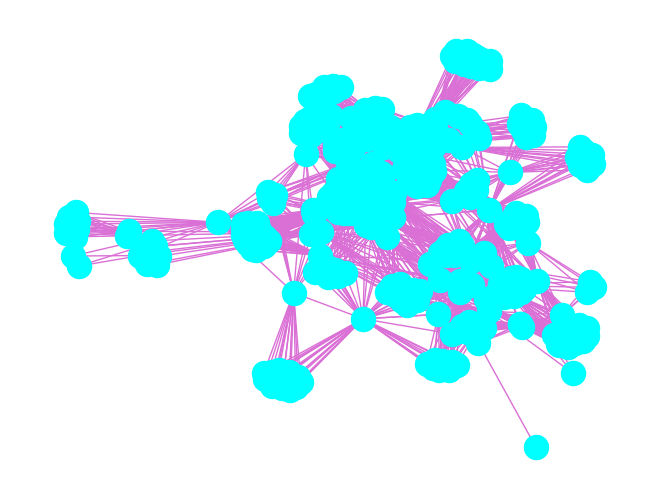

In [36]:
# Grafo bipartito entre municipios e instituciones

G_bipartitoR = nx.Graph()
for index, row in resultado.iterrows():
    G_bipartitoR.add_edge(row['Institucion'], row['Proveedor'])

# Proyectar el grafo bipartito sobre los proveedores
G_R = nx.bipartite.weighted_projected_graph(G_bipartitoR, resultado['Proveedor'].unique())

# Visualización básica del grafo (opcional)
nx.draw(G_R, with_labels=False, node_color='cyan', edge_color='orchid')

In [37]:
# Generar archivo excel del grafo 
# Crear una lista de aristas (conexiones) con sus pesos
edges = [(u, v, d['weight']) for u, v, d in G_R.edges(data=True)]

# Convertir a un DataFrame
df_edges = pd.DataFrame(edges, columns=['Proveedor 1', 'Proveedor 2', 'Peso'])

# Guardar el DataFrame como un archivo Excel
df_edges.to_excel('grafo_resultados.xlsx', index=False)

print("Archivo Excel generado exitosamente.")


Archivo Excel generado exitosamente.


In [38]:
print("Número de nodos en G_bipartitoR:", G_bipartitoR.number_of_nodes())
print("Número de aristas en G_bipartitoR:", G_bipartitoR.number_of_edges())

print("Número de nodos en G_R:", G_R.number_of_nodes())
print("Número de aristas en G_R:", G_R.number_of_edges())

Número de nodos en G_bipartitoR: 462
Número de aristas en G_bipartitoR: 572
Número de nodos en G_R: 432
Número de aristas en G_R: 9187


**Estadística descritptiva**

**Red de proveedores que participaron**

In [41]:
calculate_basic_measures(G_P)

**********************************
Número de nodos: 879
Número de enlaces: 55296
Grado mínimo: 2
Grado máximo: 825
Grado promedio: 125.81569965870307
**********************************


**Red de proveedores que ganaron**

In [43]:
calculate_basic_measures(G_R)

**********************************
Número de nodos: 432
Número de enlaces: 9187
Grado mínimo: 1
Grado máximo: 169
Grado promedio: 42.532407407407405
**********************************


### Análisis de centralidad

**Centralidad de grado**: Determina que proveedores son más competitivos en cada etapa. 

**Participación**

In [47]:
degree = nx.degree_centrality(G_P) 

# Ordenar los nodos por centralidad en orden descendente
top_10_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]

# Imprimir solo los 10 primeros nodos y su centralidad
for nodo, centralidad in top_10_degree:
    print(f"El nodo {nodo} tiene centralidad: {centralidad}")

El nodo PUBLICTRAIL INVESTMENT LIMITADA tiene centralidad: 0.9396355353075171
El nodo ADJUDICACHILE CONSULTORES SPA tiene centralidad: 0.929384965831435
El nodo  ***BLOQUEADO MEDIDA CONFIRMADA ***  ***BLOQUEADO MEDIDA CONFIRMADA *** INGENIERÍA Y LOGÍSTICA PUBLICTRAIL INVESTMENT LIMITADA tiene centralidad: 0.8325740318906606
El nodo david vilches tiene centralidad: 0.5888382687927107
El nodo INGENIERÍA Y SERVICIOS EASYSERVICE LIMITADA tiene centralidad: 0.5865603644646925
El nodo GREEN PEST CONTROL SPA tiene centralidad: 0.5751708428246013
El nodo OMAR ALEJANDRO RICOUZ BERGEN tiene centralidad: 0.561503416856492
El nodo INMOBILIARIA L + C  SPA tiene centralidad: 0.5489749430523918
El nodo MORALES HERMANOS INGENIERÍA LIMITADA tiene centralidad: 0.5466970387243736
El nodo TRANSPORTES Y SERVICIOS OSMAR SPA tiene centralidad: 0.5193621867881548


**Resultados** 

In [49]:
degree_R = nx.degree_centrality(G_R) 

# Ordenar los nodos por centralidad en orden descendente
top_10_degree_R = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]

# Imprimir solo los 10 primeros nodos y su centralidad
for nodo, centralidad in top_10_degree:
    print(f"El nodo {nodo} tiene centralidad: {centralidad}")

El nodo PUBLICTRAIL INVESTMENT LIMITADA tiene centralidad: 0.9396355353075171
El nodo ADJUDICACHILE CONSULTORES SPA tiene centralidad: 0.929384965831435
El nodo  ***BLOQUEADO MEDIDA CONFIRMADA ***  ***BLOQUEADO MEDIDA CONFIRMADA *** INGENIERÍA Y LOGÍSTICA PUBLICTRAIL INVESTMENT LIMITADA tiene centralidad: 0.8325740318906606
El nodo david vilches tiene centralidad: 0.5888382687927107
El nodo INGENIERÍA Y SERVICIOS EASYSERVICE LIMITADA tiene centralidad: 0.5865603644646925
El nodo GREEN PEST CONTROL SPA tiene centralidad: 0.5751708428246013
El nodo OMAR ALEJANDRO RICOUZ BERGEN tiene centralidad: 0.561503416856492
El nodo INMOBILIARIA L + C  SPA tiene centralidad: 0.5489749430523918
El nodo MORALES HERMANOS INGENIERÍA LIMITADA tiene centralidad: 0.5466970387243736
El nodo TRANSPORTES Y SERVICIOS OSMAR SPA tiene centralidad: 0.5193621867881548


**Centralidad de intermediación**: Identifica a proveedores que actúan como "puentes” dentro de la red de competencia. Proveedores con alta intermediación pueden conectar diferentes grupos de competencia y, por tanto, son relevantes en el flujo de información y recursos entre comunidades de proveedores.

**Participación**

In [52]:
degree_b = nx.betweenness_centrality(G_P) 

# Ordenar los nodos en orden descendente
top_10_degree_b = sorted(degree_b.items(), key=lambda x: x[1], reverse=True)[:10]

# Imprimir solo los 10 primeros nodos
for nodo, centralidad in top_10_degree_b:
    print(f"El nodo {nodo} tiene de intermediación: {centralidad}")

El nodo ADJUDICACHILE CONSULTORES SPA tiene de intermediación: 0.12640559940704107
El nodo PUBLICTRAIL INVESTMENT LIMITADA tiene de intermediación: 0.11480228552254162
El nodo  ***BLOQUEADO MEDIDA CONFIRMADA ***  ***BLOQUEADO MEDIDA CONFIRMADA *** INGENIERÍA Y LOGÍSTICA PUBLICTRAIL INVESTMENT LIMITADA tiene de intermediación: 0.06636090044334429
El nodo TRANSPORTES Y SERVICIOS OSMAR SPA tiene de intermediación: 0.03306291553294533
El nodo GREEN PEST CONTROL SPA tiene de intermediación: 0.019665507018067633
El nodo david vilches tiene de intermediación: 0.01945643457523412
El nodo OMAR ALEJANDRO RICOUZ BERGEN tiene de intermediación: 0.01713937135199066
El nodo INGENIERÍA Y SERVICIOS EASYSERVICE LIMITADA tiene de intermediación: 0.017099660030566302
El nodo INVERSIONES KYT SPA tiene de intermediación: 0.01637564243975289
El nodo ADMINISTRACION E INFRAESTRUCTURA SPA tiene de intermediación: 0.014245301268473985


**Resultados**

In [54]:
degree_b_R = nx.betweenness_centrality(G_R) 

# Ordenar los nodos en orden descendente
top_10_degree_b_R = sorted(degree_b.items(), key=lambda x: x[1], reverse=True)[:10]

# Imprimir solo los 10 primeros nodos
for nodo, centralidad in top_10_degree_b:
    print(f"El nodo {nodo} tiene de intermediación: {centralidad}")

El nodo ADJUDICACHILE CONSULTORES SPA tiene de intermediación: 0.12640559940704107
El nodo PUBLICTRAIL INVESTMENT LIMITADA tiene de intermediación: 0.11480228552254162
El nodo  ***BLOQUEADO MEDIDA CONFIRMADA ***  ***BLOQUEADO MEDIDA CONFIRMADA *** INGENIERÍA Y LOGÍSTICA PUBLICTRAIL INVESTMENT LIMITADA tiene de intermediación: 0.06636090044334429
El nodo TRANSPORTES Y SERVICIOS OSMAR SPA tiene de intermediación: 0.03306291553294533
El nodo GREEN PEST CONTROL SPA tiene de intermediación: 0.019665507018067633
El nodo david vilches tiene de intermediación: 0.01945643457523412
El nodo OMAR ALEJANDRO RICOUZ BERGEN tiene de intermediación: 0.01713937135199066
El nodo INGENIERÍA Y SERVICIOS EASYSERVICE LIMITADA tiene de intermediación: 0.017099660030566302
El nodo INVERSIONES KYT SPA tiene de intermediación: 0.01637564243975289
El nodo ADMINISTRACION E INFRAESTRUCTURA SPA tiene de intermediación: 0.014245301268473985


**Centralidad de cercania**: Los proveedores con alta cercanía sugiere que tienen una posición ventajosa en términos de acceso a otros competidores en el ecosistema de licitaciones.

**Participación**

In [57]:
degree_c = nx.closeness_centrality(G_P) 

# Ordenar los nodos por centralidad en orden descendente
top_10_degree_c = sorted(degree_c.items(), key=lambda x: x[1], reverse=True)[:10]

# Imprimir solo los 10 primeros nodos
for nodo, centralidad in top_10_degree_c:
    print(f"El nodo {nodo} tiene closeness: {centralidad}")

El nodo PUBLICTRAIL INVESTMENT LIMITADA tiene closeness: 0.9430719656283566
El nodo ADJUDICACHILE CONSULTORES SPA tiene closeness: 0.9340425531914893
El nodo  ***BLOQUEADO MEDIDA CONFIRMADA ***  ***BLOQUEADO MEDIDA CONFIRMADA *** INGENIERÍA Y LOGÍSTICA PUBLICTRAIL INVESTMENT LIMITADA tiene closeness: 0.8565853658536585
El nodo david vilches tiene closeness: 0.7074939564867043
El nodo INGENIERÍA Y SERVICIOS EASYSERVICE LIMITADA tiene closeness: 0.7063555913113435
El nodo GREEN PEST CONTROL SPA tiene closeness: 0.7018385291766587
El nodo OMAR ALEJANDRO RICOUZ BERGEN tiene closeness: 0.6940711462450593
El nodo INMOBILIARIA L + C  SPA tiene closeness: 0.6880877742946708
El nodo MORALES HERMANOS INGENIERÍA LIMITADA tiene closeness: 0.6870109546165885
El nodo TRANSPORTES Y SERVICIOS OSMAR SPA tiene closeness: 0.6753846153846154


**Resultados**

In [59]:
degree_c_R = nx.closeness_centrality(G_R) 

# Ordenar los nodos por centralidad en orden descendente
top_10_degree_c_R = sorted(degree_c.items(), key=lambda x: x[1], reverse=True)[:10]

# Imprimir solo los 10 primeros nodos
for nodo, centralidad in top_10_degree_c:
    print(f"El nodo {nodo} tiene closeness: {centralidad}")

El nodo PUBLICTRAIL INVESTMENT LIMITADA tiene closeness: 0.9430719656283566
El nodo ADJUDICACHILE CONSULTORES SPA tiene closeness: 0.9340425531914893
El nodo  ***BLOQUEADO MEDIDA CONFIRMADA ***  ***BLOQUEADO MEDIDA CONFIRMADA *** INGENIERÍA Y LOGÍSTICA PUBLICTRAIL INVESTMENT LIMITADA tiene closeness: 0.8565853658536585
El nodo david vilches tiene closeness: 0.7074939564867043
El nodo INGENIERÍA Y SERVICIOS EASYSERVICE LIMITADA tiene closeness: 0.7063555913113435
El nodo GREEN PEST CONTROL SPA tiene closeness: 0.7018385291766587
El nodo OMAR ALEJANDRO RICOUZ BERGEN tiene closeness: 0.6940711462450593
El nodo INMOBILIARIA L + C  SPA tiene closeness: 0.6880877742946708
El nodo MORALES HERMANOS INGENIERÍA LIMITADA tiene closeness: 0.6870109546165885
El nodo TRANSPORTES Y SERVICIOS OSMAR SPA tiene closeness: 0.6753846153846154


In [234]:
# Calcular las centralidades para todos los nodos en el grafo
degree_b = nx.betweenness_centrality(G_P) 
degree_c = nx.closeness_centrality(G_P) 
degree_R = nx.degree_centrality(G_P) 

# Convertir cada resultado de centralidad a un DataFrame completo
df_degree_b = pd.DataFrame(degree_b.items(), columns=['Proveedor', 'Centralidad_Intermediacion'])
df_degree_c = pd.DataFrame(degree_c.items(), columns=['Proveedor', 'Centralidad_Cercania'])
df_degree = pd.DataFrame(degree.items(), columns=['Proveedor', 'Centralidad_Grado'])

# Combinar todos los DataFrames en uno solo por la columna 'Proveedor'
centralidades_participacion = df_degree_b.merge(df_degree_c, on='Proveedor').merge(df_degree, on='Proveedor')

# Crear un archivo Excel y guardar el DataFrame combinado en una sola hoja
centralidades_participacion.to_excel('centralidad_resultados.xlsx', sheet_name='Sheet1', index=False)

print("Archivo 'centralidad_resultados.xlsx' generado con todos los resultados de centralidad en una sola hoja para cada proveedor.")


Archivo 'centralidad_resultados.xlsx' generado con todos los resultados de centralidad en una sola hoja para cada proveedor.


In [236]:
# Calcular las centralidades para todos los nodos en el grafo
degree_b_R = nx.betweenness_centrality(G_R) 
degree_c_R = nx.closeness_centrality(G_R) 
degree_R = nx.degree_centrality(G_R) 

# Convertir cada resultado de centralidad a un DataFrame completo
df_degree_b_R = pd.DataFrame(degree_b_R.items(), columns=['Proveedor', 'Centralidad_Intermediacion'])
df_degree_c_R = pd.DataFrame(degree_c_R.items(), columns=['Proveedor', 'Centralidad_Cercania'])
df_degree_R = pd.DataFrame(degree_R.items(), columns=['Proveedor', 'Centralidad_Grado'])

# Combinar todos los DataFrames en uno solo por la columna 'Proveedor'
centralidades_resultados = df_degree_b_R.merge(df_degree_c_R, on='Proveedor').merge(df_degree_R, on='Proveedor')

# Crear un archivo Excel y guardar el DataFrame combinado en una sola hoja
centralidades_resultados.to_excel('centralidad_resultados.xlsx', sheet_name='Sheet1', index=False)

print("Archivo 'centralidad_resultados.xlsx' generado con todos los resultados de centralidad en una sola hoja para cada proveedor.")


Archivo 'centralidad_resultados.xlsx' generado con todos los resultados de centralidad en una sola hoja para cada proveedor.


### Tabla resumen: centralidad 

In [182]:
# Cargar el archivo Excel recién subido para asegurar que estamos trabajando con la versión más reciente
file_path_updated = 'centralidad_total.xlsx'
excel_data_updated = pd.ExcelFile(file_path_updated)

# Inicializar un diccionario para almacenar la información de ubicación de los proveedores en cada hoja
provider_location_data = {}

# Iterar sobre cada hoja en el archivo actualizado y recopilar los datos de "Proveedor" y "Ubicación"
for sheet in excel_data_updated.sheet_names:
    # Leer los datos de la hoja
    sheet_df = excel_data_updated.parse(sheet)
    
    # Determinar las columnas de "Proveedor" y "Ubicación" basándose en el contenido de la hoja
    provider_column = 'Proveedor' if 'Proveedor' in sheet_df.columns else 'Nodo' if 'Nodo' in sheet_df.columns else None
    location_column = 'Ubicación' if 'Ubicación' in sheet_df.columns else None
    
    # Si ambas columnas están presentes, extraer los datos relevantes
    if provider_column and location_column:
        for _, row in sheet_df.dropna(subset=[provider_column]).iterrows():
            provider = row[provider_column]
            location = row[location_column]
            
            # Inicializar la entrada del proveedor si no está presente en el diccionario
            if provider not in provider_location_data:
                provider_location_data[provider] = {}
            
            # Agregar datos de ubicación bajo el nombre de la hoja actual
            provider_location_data[provider][sheet] = location

# Convertir el diccionario en un DataFrame para visualización y nombrar la columna 'Proveedor'
provider_location_table = pd.DataFrame(provider_location_data).T.fillna("No Data").reset_index()
provider_location_table.rename(columns={'index': 'Proveedor'}, inplace=True)

# Mostrar las primeras 16 filas del DataFrame resultante para ver el formato
provider_location_table.head(16)


,Proveedor,centrality_part,closeness_part,betweenness_part,centrality resul,betweenness_result,closeness_part_result
0,PUBLICTRAIL INVESTMENT LIMITADA,1.0,1.0,2.0,No Data,No Data,No Data
1,ADJUDICACHILE CONSULTORES SPA,2.0,2.0,1.0,No Data,No Data,No Data
2,***BLOQUEADO MEDIDA CONFIRMADA *** ***BLOQUE...,3.0,3.0,3.0,No Data,No Data,No Data
3,david vilches,4.0,4.0,6.0,23.0,26.0,9.0
4,INGENIERÍA Y SERVICIOS EASYSERVICE LIMITADA,5.0,5.0,8.0,No Data,No Data,No Data
5,GREEN PEST CONTROL SPA,6.0,6.0,5.0,No Data,No Data,No Data
6,OMAR ALEJANDRO RICOUZ BERGEN,7.0,7.0,7.0,No Data,No Data,No Data
7,INMOBILIARIA L + C SPA,8.0,8.0,12.0,3.0,1.0,1.0
8,MORALES HERMANOS INGENIERÍA LIMITADA,9.0,9.0,11.0,42.0,119.0,73.0
9,TRANSPORTES Y SERVICIOS OSMAR SPA,10.0,10.0,4.0,102.0,2.0,25.0


### Detección de comunidades

La detección de comunidades se realizó mediante tres algoritmos principales: Louvain, Fast Greedy y Propagación de Etiquetas (Label Propagation). Cada uno de estos algoritmos agrupa a los proveedores en comunidades de competencia, donde los proveedores dentro de la misma comunidad tienen mayor interacción o competencia entre ellos.

Estas comunidades de competencia permiten identificar si existen “clústeres” de proveedores que compiten regularmente en licitaciones organizadas por ciertos municipios o en sectores específicos como Servicio de contrucción.


### Comunidad: proveedores participantes

In [66]:
# Función para obtener una lista de colores aleatorios
def get_distinct_colors(n):
    colors = list(mcolors.CSS4_COLORS.keys())
    random.shuffle(colors)
    return colors[:n]

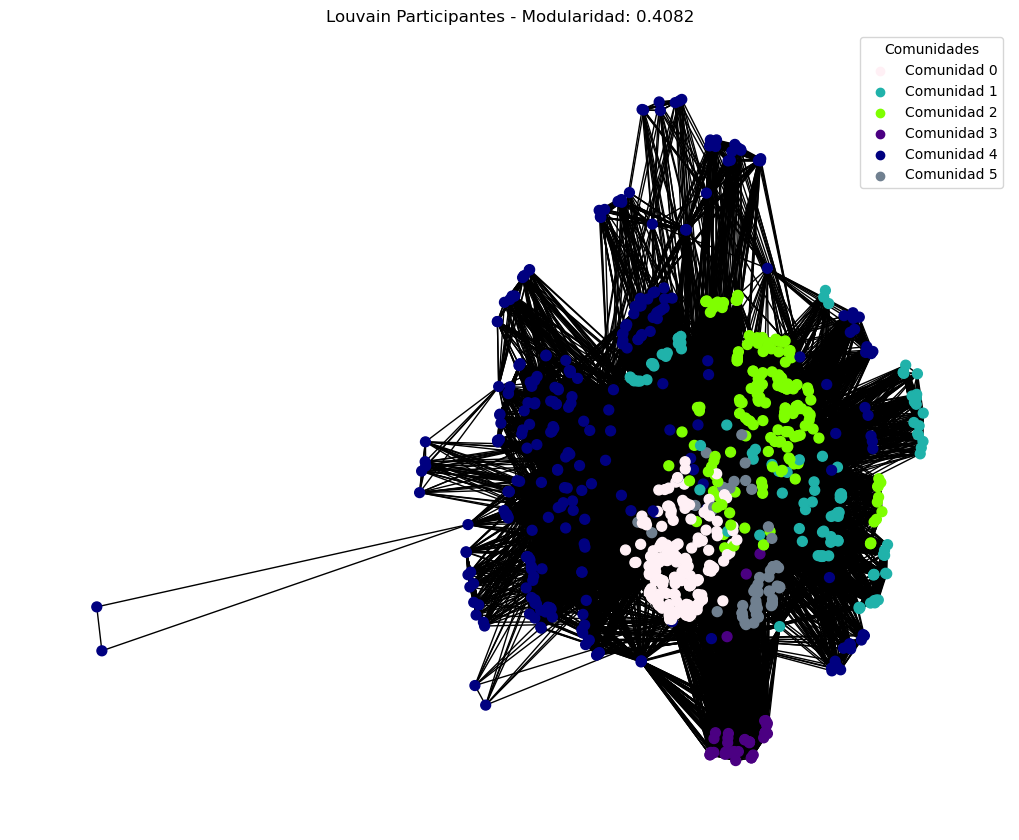

Archivo Excel con comunidades generado exitosamente.
{'Louvain': {'communities': [], 'modularity': 0.40822576862991417, 'num_communities': 6}}


In [67]:
# Función para calcular y graficar comunidades con colores distintos, y con una leyenda que asocie color-comunidad
def calculate_and_plot_communities(algorithm_name, communities, modularity_value, G, color_scheme):
    # Asignar colores a los nodos basados en la comunidad a la que pertenecen
    node_colors = {}
    community_color_map = {}  # Para guardar el color de cada comunidad

    for i, community in enumerate(communities):
        color = color_scheme[i]  # Obtener color específico para la comunidad
        community_color_map[i] = color  # Guardar el color de la comunidad
        for node in community:
            node_colors[node] = color  # Asignar el color al nodo

    # Extraer colores de los nodos
    colors = [node_colors[node] for node in G.nodes()]
    
    # Dibujar el grafo
    plt.figure(figsize=(10, 8))
    nx.draw(G, node_color=colors, with_labels=False, node_size=50)
    plt.title(f"{algorithm_name} - Modularidad: {modularity_value:.4f}")

    # Agregar leyenda para cada comunidad
    for community, color in community_color_map.items():
        plt.scatter([], [], color=color, label=f'Comunidad {community}')
    plt.legend(title="Comunidades", loc='best')
    plt.show()

# Aplicación del algoritmo de Louvain
communities_louvain = louvain_communities(G_P, seed=42)
modularity_louvain = modularity(G_P, communities_louvain)
num_communities_louvain = len(communities_louvain)  # Cantidad de comunidades encontradas

# Guardar los resultados en un diccionario
results = {
    "Louvain": {
        "communities": communities_louvain[:0],  
        "modularity": modularity_louvain,
        "num_communities": num_communities_louvain
    }
}

# Generar colores distintos para cada comunidad y graficar con leyenda
distinct_colors_louvain = get_distinct_colors(num_communities_louvain)
calculate_and_plot_communities("Louvain Participantes", communities_louvain, modularity_louvain, G_P, distinct_colors_louvain)

# Crear un DataFrame para las comunidades de Louvain
community_data = []
for i, community in enumerate(communities_louvain):
    for node in community:
        community_data.append({"Community": i, "Proveedor": node})

df_communities = pd.DataFrame(community_data)

# Guardar el DataFrame en un archivo Excel
df_communities.to_excel("comunidades_louvain_participantes.xlsx", index=False)
print("Archivo Excel con comunidades generado exitosamente.")

print(results)


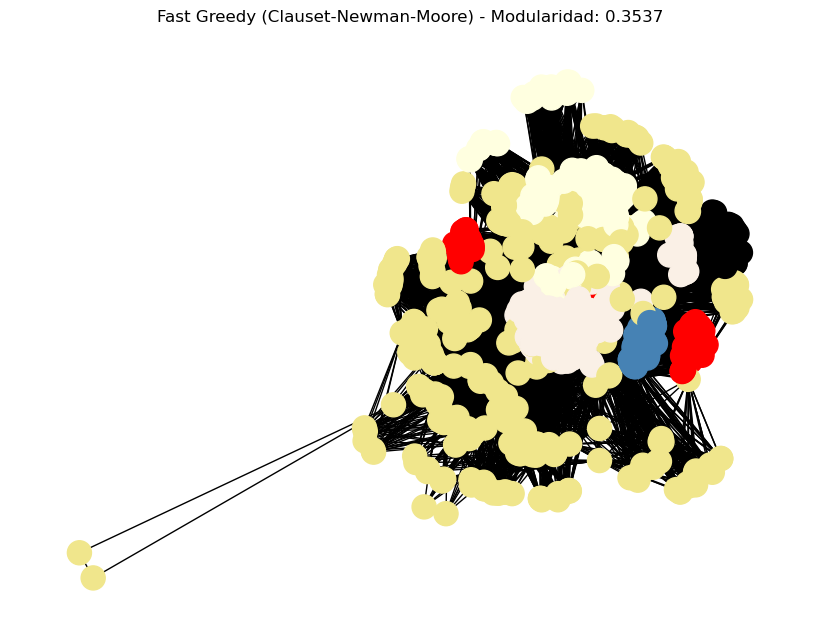

{'Fast Greedy (Clauset-Newman-Moore)': {'communities': [],
  'modularity': 0.3536790750716235,
  'num_communities': 6}}

In [68]:
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

# Función para calcular y graficar comunidades con colores distintos
def calculate_and_plot_communities(algorithm_name, communities, modularity_value, G, color_scheme):
    # Asignar colores a los nodos basados en la comunidad a la que pertenecen
    node_colors = {}
    for i, community in enumerate(communities):
        color = color_scheme[i]  # Obtener color específico para la comunidad
        for node in community:
            node_colors[node] = color  # Asignar el color

    colors = [node_colors[node] for node in G.nodes()]
    plt.figure(figsize=(8, 6))
    nx.draw(G, node_color=colors, with_labels=False)
    plt.title(f"{algorithm_name} - Modularidad: {modularity_value:.4f}")
    plt.show()

# Aplicación del algoritmo Fast Greedy (Clauset-Newman-Moore)
communities_fast_greedy = list(greedy_modularity_communities(G_P))
modularity_fast_greedy = modularity(G_P, communities_fast_greedy)
num_communities_fast_greedy = len(communities_fast_greedy)  # Cantidad de comunidades encontradas

# Guardar los resultados en un diccionario
results = {
    "Fast Greedy (Clauset-Newman-Moore)": {
        "communities": communities_fast_greedy[:0], 
        "modularity": modularity_fast_greedy,
        "num_communities": num_communities_fast_greedy
    }
}

# Generar colores distintos para cada comunidad y graficar
distinct_colors_fast_greedy = get_distinct_colors(num_communities_fast_greedy)
calculate_and_plot_communities("Fast Greedy (Clauset-Newman-Moore)", communities_fast_greedy, modularity_fast_greedy, G_P, distinct_colors_fast_greedy)

# Mostrar resultados
results


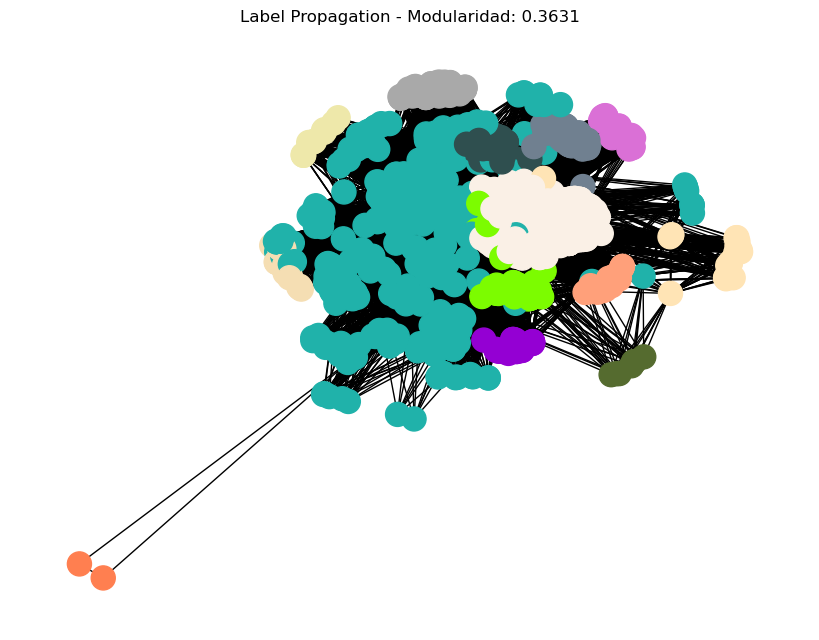

{'Label Propagation': {'communities': [],
  'modularity': 0.36305675938364845,
  'num_communities': 14}}

In [69]:
from networkx.algorithms.community import asyn_lpa_communities
from networkx.algorithms.community.quality import modularity

# Función para calcular y graficar comunidades con colores distintos
def calculate_and_plot_communities(algorithm_name, communities, modularity_value, G, color_scheme):
    # Asignar colores a los nodos basados en la comunidad a la que pertenecen
    node_colors = {}
    for i, community in enumerate(communities):
        color = color_scheme[i]  # Obtener color específico para la comunidad
        for node in community:
            node_colors[node] = color  # Asignar el color

    colors = [node_colors[node] for node in G_P.nodes()]
    plt.figure(figsize=(8, 6))
    nx.draw(G, node_color=colors, with_labels=False)
    plt.title(f"{algorithm_name} - Modularidad: {modularity_value:.4f}")
    plt.show()


# Aplicación del algoritmo de Propagación de Etiquetas (Label Propagation)
communities_label_propagation = list(asyn_lpa_communities(G_P, seed=42))
modularity_label_propagation = modularity(G_P, communities_label_propagation)
num_communities_label_propagation = len(communities_label_propagation)  # Cantidad de comunidades encontradas

# Guardar los resultados en un diccionario
results = {
    "Label Propagation": {
    "communities": communities_label_propagation[:0],  # Detalle de una comunidad como ejemplo
    "modularity": modularity_label_propagation,
    "num_communities": num_communities_label_propagation
    }
}

# Generar colores distintos para cada comunidad y graficar
distinct_colors_label_propagation = get_distinct_colors(num_communities_label_propagation)
calculate_and_plot_communities("Label Propagation", communities_label_propagation, modularity_label_propagation, G_P, distinct_colors_label_propagation)

# Mostrar resultados
results


### Comunidad: proveedores ganadores

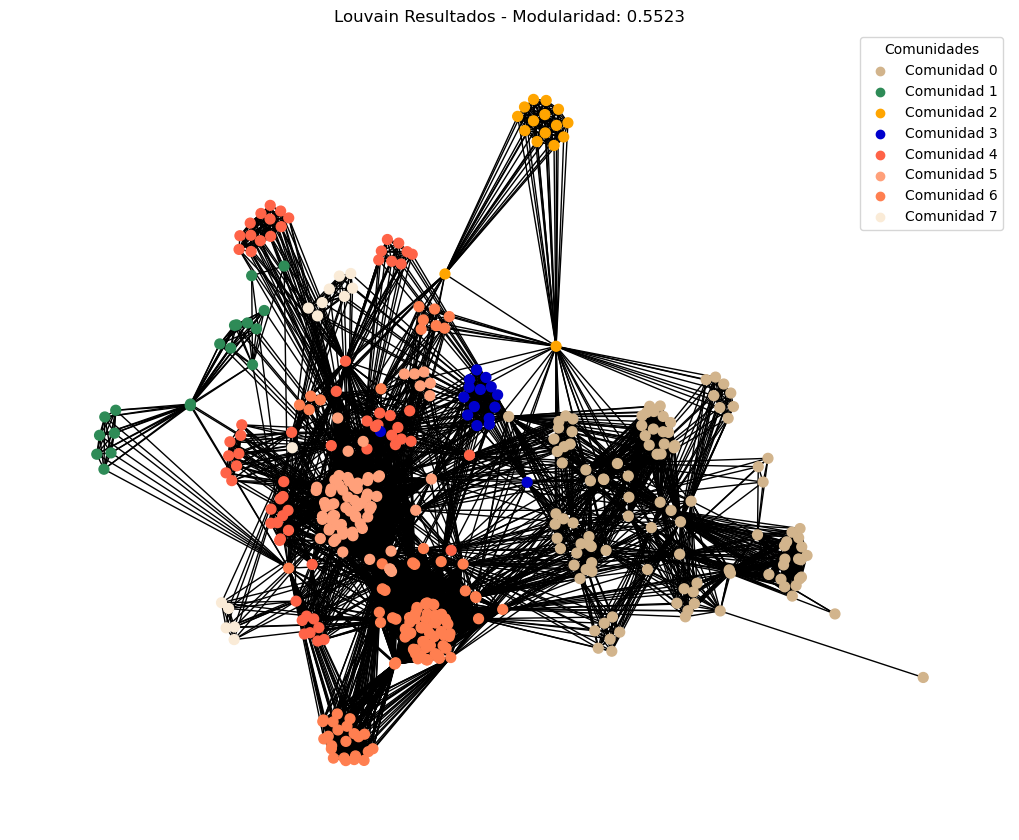

Archivo Excel con comunidades generado exitosamente.
{'Louvain': {'communities': [], 'modularity': 0.5522559689650071, 'num_communities': 8}}


In [71]:
def calculate_and_plot_communities(algorithm_name, communities, modularity_value, G, color_scheme):
    # Asignar colores a los nodos basados en la comunidad a la que pertenecen
    node_colors = {}
    community_color_map = {}  # Para guardar el color de cada comunidad

    for i, community in enumerate(communities):
        color = color_scheme[i]  # Obtener color específico para la comunidad
        community_color_map[i] = color  # Guardar el color de la comunidad
        for node in community:
            node_colors[node] = color  # Asignar el color al nodo

    # Extraer colores de los nodos
    colors = [node_colors[node] for node in G.nodes()]
    
    # Dibujar el grafo
    plt.figure(figsize=(10, 8))
    nx.draw(G, node_color=colors, with_labels=False, node_size=50)
    plt.title(f"{algorithm_name} - Modularidad: {modularity_value:.4f}")

    # Agregar leyenda para cada comunidad
    for community, color in community_color_map.items():
        plt.scatter([], [], color=color, label=f'Comunidad {community}')
    plt.legend(title="Comunidades", loc='best')
    plt.show()

# Aplicación del algoritmo de Louvain
communities_louvain = louvain_communities(G_R, seed=42)
modularity_louvain = modularity(G_R, communities_louvain)
num_communities_louvain = len(communities_louvain)  # Cantidad de comunidades encontradas

# Guardar los resultados en un diccionario
results = {
    "Louvain": {
        "communities": communities_louvain[:0],  
        "modularity": modularity_louvain,
        "num_communities": num_communities_louvain
    }
}

# Generar colores distintos para cada comunidad y graficar con leyenda
distinct_colors_louvain = get_distinct_colors(num_communities_louvain)
calculate_and_plot_communities("Louvain Resultados", communities_louvain, modularity_louvain, G_R, distinct_colors_louvain)

# Crear un DataFrame para las comunidades de Louvain
community_data = []
for i, community in enumerate(communities_louvain):
    for node in community:
        community_data.append({"Community": i, "Proveedor": node})

df_communities = pd.DataFrame(community_data)

# Guardar el DataFrame en un archivo Excel
df_communities.to_excel("comunidades_louvain_resultados.xlsx", index=False)
print("Archivo Excel con comunidades generado exitosamente.")

print(results)

**Analisis de datos cruzados**

In [224]:
# Cargar los archivos Excel adjuntos

comunidades_louvain_participantes = pd.read_excel("comunidades_louvain_participantes.xlsx")
centralidad_participantes = pd.read_excel("centralidad_participantes.xlsx")

# Obtener comunidades únicas y asignar colores
unique_communities = comunidades_louvain_participantes['Community'].unique()
color_scheme = get_distinct_colors(len(unique_communities))
community_color_map = {community: color for community, color in zip(unique_communities, color_scheme)}

# Agregar la columna de color en el DataFrame de comunidades
comunidades_louvain_participantes['Color'] = comunidades_louvain_participantes['Community'].map(community_color_map)

# Cruzar los datos de comunidades con las métricas de centralidad para análisis
merged_participantes = pd.merge(comunidades_louvain_participantes, centralidad_participantes, left_on="Proveedor", right_on="Proveedor")

# Guardar el resultado en un archivo Excel para facilitar el análisis
merged_participantes.to_excel("comunidades_y_centralidad_participantes.xlsx", index=False)
print("Archivo 'comunidades_y_centralidad_partipantes.xlsx' generado exitosamente.")


Archivo 'comunidades_y_centralidad_partipantes.xlsx' generado exitosamente.


In [250]:
# Cargar los archivos Excel adjuntos

comunidades_louvain_resultados = pd.read_excel("comunidades_louvain_resultados.xlsx")
centralidad_resultados = pd.read_excel("centralidad_resultados.xlsx")

# Obtener comunidades únicas y asignar colores
unique_communities = comunidades_louvain_resultados['Community'].unique()
color_scheme = get_distinct_colors(len(unique_communities))
community_color_map = {community: color for community, color in zip(unique_communities, color_scheme)}

# Agregar la columna de color en el DataFrame de comunidades
comunidades_louvain_resultados['Color'] = comunidades_louvain_resultados['Community'].map(community_color_map)

# Cruzar los datos de comunidades con las métricas de centralidad para análisis
merged_resultados = pd.merge(comunidades_louvain_resultados, centralidad_resultados, left_on="Proveedor", right_on="Proveedor")

# Mostrar las columnas de merged_resultados
print(merged_resultados.columns.tolist())

# Guardar el resultado en un archivo Excel para facilitar el análisis
merged_resultados.to_excel("comunidades_y_centralidad_resultados.xlsx", index=False)
print("generado exitosamente.")


['Community', 'Proveedor', 'Color', 'Centralidad_Intermediacion', 'Centralidad_Cercania', 'Centralidad_Grado']
generado exitosamente.


#### Tabla resumen: Comunidades

In [255]:
# Renombrar columnas para claridad
merged_resultados.rename(columns={'Community': 'Community_Ganadores'}, inplace=True)
merged_participantes.rename(columns={'Community': 'Community_Participacion'}, inplace=True)
provider_location_table.rename(columns={'centrality resul': 'Centrality_Resul'}, inplace=True)

# Primero, realizar el merge de los dos primeros DataFrames
tabla_comunidades = pd.merge(merged_resultados, merged_participantes, on='Proveedor', how='inner')

# Luego, realizar el merge con el tercer DataFrame
tabla_comunidades = pd.merge(tabla_comunidades, provider_location_table, on='Proveedor', how='inner')

# Seleccionar solo columnas específicas y ordenar según 'Centrality_Resul'
comunidades = tabla_comunidades[['Proveedor', 'Community_Ganadores', 'Community_Participacion', 'Centrality_Resul','betweenness_result', 'closeness_part_result']]
tabla_final_comunidades = comunidades.sort_values(by='Centrality_Resul').head(12)

tabla_final_comunidades

,Proveedor,Community_Ganadores,Community_Participacion,Centrality_Resul,betweenness_result,closeness_part_result
254,SERVICIOS INTEGRALES F&amp S SPA,5,2,1.0,7.0,2.0
249,SURCOS SPA,5,2,2.0,15.0,4.0
345,INMOBILIARIA L + C SPA,6,1,3.0,1.0,1.0
257,DARIEN ANTONIO ALVARADO MARABOLI,5,2,4.0,28.0,5.0
271,INGENIERIA Y MANTENCION INDUSTRIAL SPA,5,2,5.0,29.0,7.0
283,ROLANDO RODRIGO BAEZ LOPEZ,5,2,6.0,30.0,8.0
250,HARRO INGENIERIA & CONSULTORES LIMITADA,5,2,7.0,31.0,6.0
297,INVERSIONES KYT SPA,5,2,8.0,12.0,18.0
317,G Y C CONSTRUCCIÓN Y SERVICIOS SPA,6,5,9.0,17.0,12.0
316,BIKE RED MACHINE SPA,6,0,10.0,11.0,3.0


In [222]:
# Analizar la comunidad con proveedores de mayor relevancia según la centralidad
# Vamos a calcular el promedio de centralidad para cada comunidad y así identificar la más relevante

print('PARTICIPACION')
print('==================================================')


# Calcular la media de cada métrica de centralidad por comunidad
centralidad_media_por_comunidad = merged_participantes.groupby("Community")[
    ["Centralidad_Grado", "Centralidad_Intermediacion", "Centralidad_Cercania"]
].mean()

print(centralidad_media_por_comunidad)

# Identificar la comunidad con el valor más alto de cada métrica de centralidad
comunidad_mayor_centralidad_grado = centralidad_media_por_comunidad["Centralidad_Grado"].idxmax()
comunidad_mayor_centralidad_intermediacion = centralidad_media_por_comunidad["Centralidad_Intermediacion"].idxmax()
comunidad_mayor_centralidad_cercania = centralidad_media_por_comunidad["Centralidad_Cercania"].idxmax()



# Extraer los valores correspondientes
valores_mayor_centralidad = {
    "Centralidad_Grado": (comunidad_mayor_centralidad_grado, 
                          centralidad_media_por_comunidad.loc[comunidad_mayor_centralidad_grado, "Centralidad_Grado"]),
    "Centralidad_Intermediacion": (comunidad_mayor_centralidad_intermediacion, 
                                   centralidad_media_por_comunidad.loc[comunidad_mayor_centralidad_intermediacion, "Centralidad_Intermediacion"]),
    "Centralidad_Cercania": (comunidad_mayor_centralidad_cercania, 
                             centralidad_media_por_comunidad.loc[comunidad_mayor_centralidad_cercania, "Centralidad_Cercania"])
}

valores_mayor_centralidad


PARTICIPACION
           Centralidad_Grado  Centralidad_Intermediacion  Centralidad_Cercania
Community                                                                     
0                   0.282195                    0.000730              0.580321
1                   0.084314                    0.000543              0.522449
2                   0.164446                    0.001085              0.545945
3                   0.071060                    0.000096              0.515854
4                   0.066095                    0.001415              0.515661
5                   0.140523                    0.000909              0.538671


{'Centralidad_Grado': (0, 0.2821951329529308),
 'Centralidad_Intermediacion': (4, 0.0014154718554193152),
 'Centralidad_Cercania': (0, 0.5803205062239454)}

In [252]:
# Calcular la media de cada métrica de centralidad por comunidad

print('RESULTADOS')
print('==================================================')

centralidad_media_por_comunidad = merged_resultados.groupby("Community")[
    ["Centralidad_Grado", "Centralidad_Intermediacion", "Centralidad_Cercania"]
].mean()

print(centralidad_media_por_comunidad)

# Identificar la comunidad con el valor más alto de cada métrica de centralidad
comunidad_mayor_centralidad_grado = centralidad_media_por_comunidad["Centralidad_Grado"].idxmax()
comunidad_mayor_centralidad_intermediacion = centralidad_media_por_comunidad["Centralidad_Intermediacion"].idxmax()
comunidad_mayor_centralidad_cercania = centralidad_media_por_comunidad["Centralidad_Cercania"].idxmax()

# Extraer los valores correspondientes
valores_mayor_centralidad = {
    "Centralidad_Grado": (comunidad_mayor_centralidad_grado, 
                          centralidad_media_por_comunidad.loc[comunidad_mayor_centralidad_grado, "Centralidad_Grado"]),
    "Centralidad_Intermediacion": (comunidad_mayor_centralidad_intermediacion, 
                                   centralidad_media_por_comunidad.loc[comunidad_mayor_centralidad_intermediacion, "Centralidad_Intermediacion"]),
    "Centralidad_Cercania": (comunidad_mayor_centralidad_cercania, 
                             centralidad_media_por_comunidad.loc[comunidad_mayor_centralidad_cercania, "Centralidad_Cercania"])
}

valores_mayor_centralidad


RESULTADOS
           Centralidad_Grado  Centralidad_Intermediacion  Centralidad_Cercania
Community                                                                     
0                   0.055622                    0.002816              0.389919
1                   0.022958                    0.000576              0.335343
2                   0.041618                    0.005417              0.344835
3                   0.048434                    0.001408              0.414786
4                   0.049099                    0.001948              0.407693
5                   0.170534                    0.004776              0.451329
6                   0.160593                    0.004477              0.461012
7                   0.023865                    0.000531              0.383197


{'Centralidad_Grado': (5, 0.1705336426914153),
 'Centralidad_Intermediacion': (2, 0.005416840019482348),
 'Centralidad_Cercania': (6, 0.46101248471595585)}

### Análisis y conclusiones

La revisión de los índices de centralidad en la participación de los proveedores en las licitaciones del rubro y la posterior comparación con los proveedores ganadores en las mismas licitaciones lleva a considerar que los principales proveedores en el grafo participación sean descartados por dos motivos, primero, en esos dos años no ganaron ninguna licitación y segundo, uno de los proveedores fue bloqueado en Mercado Público por incumplir las bases de la institución
Revisando los índices de centralidad de ambos grafos se observa que quienes tienen altos índices en participación no son los primeros en los índices de ganadores. 
La observación de las comunidades formadas entre los ganadores y su ubicación previa en las comunidades de participación señalan que las comunidades 0 y 2 contienen a los futuros ganadores.
La comunidad 0 se destaca en la centralidad de grado y en la centralidad de cercanía dentro del grafo  de participación. Sin embargo, los proveedores que provienen de la comunidad 2 aunque no tenga el primer lugar en las centralidades de origen son los que tienen mejores indicadores de centralidad en el grafo de los proveedores ganadores.
A nivel individual, se destacan los proveedores: SERVICIOS INTEGRALES F&amp S SPA. SURCOS SPA, INMOBILIARIA L + C SPA, ADMINISTRACION E INFRAESTRUCTURA SPA los cuales forman parte tanto de la comunidad 5 o 6. 	
